# L4b: Kernel Regression of Financial Time Series Data
In this lab, we will use [kernel regression](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote14.html) to construct a model of the daily growth rate of stocks in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500).

### Tasks
Before we start, divide into teams and familiarize yourself with the lab. Then, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!

* __Task 1: Setup, Data, Constants (10 min)__: Let's take 10 minutes to explore the [Open-High-Low-Close (OHLC) dataset](https://en.wikipedia.org/wiki/Open-high-low-close_chart) we'll explore today. We'll load the full dataset, do some cleanup, scale it and then split the scaled data into training and test datasets.
* __Task 2: Build and Train Perceptron Classification Model (20 min)__: In this task, we'll build and train a Perceptron classification model, use the trained model to estimate the labels on unseen test data, and then compute the confusion matrix.
* __Task 3:  Build and Train Logistic Regression Classification Model (20 min)?__: In this task, we'll build and train a Logistic regression classification model, use the trained model to estimate the labels on unseen test data, and then compute the confusion matrix.

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl");

### Data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `02-07-2025`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];


__Clean the data__: Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

2792

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = let

    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end;

Let's get a list of firms in the cleaned up `dataset` and save it in the `all_tickers` array. We sort the firms alphabetically from `A` to `Z`:

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

Compute the expected (annualized) excess log growth rate by passing the `dataset` and the entire list of firms we have in the dataset to the [log_growth_matrix(...) method](src/Compute.jl). The log growth rate between time period $j-1$ to $j$, e.g., yesterday to today is defined as:
$$
\begin{equation}
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\ln\left(\frac{S_{j}}{S_{j-1}}\right)
\end{equation}
$$
where $\Delta{t}$ denotes the period time step, and $S_{j}$ denote share price in period $j$.
* The log growth rates are stored in the `D::Array{Float64,2}` variable, a $T-1\times{N}$ array of log return values. Each row of the `D` matrix corresponds to a time value, while each column corresponds to a firm

In [13]:
D = let

    # setup some constants -
    Δt = (1/252); # 1-trading day in units of years
    risk_free_rate = 0.0415; # inferred cc risk-free rate

    # compute
    μ = log_growth_matrix(dataset, list_of_all_tickers, Δt = Δt, 
        risk_free_rate = risk_free_rate);

    # return to caller
    μ
end

2791×424 Matrix{Float64}:
 -0.919054     6.23955    -2.91247    …   -0.796891    0.204394  -1.04677
  2.77476      1.02999     1.35089         2.09682    -0.84429    0.944968
  3.27155      0.814097   -0.036132        0.068377    1.1495    -2.62294
  0.604925    17.2184      1.65065         0.233216    3.1178    -0.409728
  1.77459      2.53811     3.27774         0.580177   -2.2102     4.36159
  0.57233     -4.00534    -0.83428    …   -0.904239   -1.95127   -3.15774
  2.81921     -0.525251    4.80423         1.7242     -1.81835   -1.1311
  2.00521      0.972004    1.86659         1.63447     4.40834   -0.179319
  1.27139      1.63263     0.0657592      -1.54858    -2.17846    1.39634
  1.17866      6.08807     0.891078       -1.57352     2.83634   -1.47776
 -0.479168     4.82859     0.96624    …   -0.362761    9.46677   -3.05023
  1.32131      3.57167    -2.38926         0.669113    4.48073    0.299031
 -4.78054      1.34435    -3.05774        -2.19395    -6.69057    1.36462
  ⋮      

Next, let's [z-score center](https://en.wikipedia.org/wiki/Feature_scaling) the continous feature data. In [z-score feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), we subtract off the mean of each feature and then divide by the standard deviation, i.e., $x^{\prime} = (x - \mu)/\sigma$ where $x$ is the unscaled data, and $x^{\prime}$ is the scaled data. Under this scaling regime, $x^{\prime}\leq{0}$ will be values that are less than or equal to the mean value $\mu$, while $x^{\prime}>0$ indicate values that are greater than the mean.

We save the z-score centered growth data data in the `D̄::Array{Float64,2}` variable:

In [15]:
D̄ = let

    # setup -
    number_of_examples = size(D,1);

    D̄ = copy(D);
    for j ∈ eachindex(list_of_all_tickers)
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̄[k,j] = (D[k,j] - μ)/σ;
        end
    end
    
    D̄
end

2791×424 Matrix{Float64}:
 -0.270236    0.875241   -0.51285    …  -0.172603    0.0340086  -0.326599
  0.735235    0.153683    0.270667       0.365351   -0.156963    0.235764
  0.870466    0.123779    0.0157621     -0.0117454   0.206118   -0.771629
  0.144598    2.39589     0.325758       0.018899    0.564557   -0.146732
  0.462985    0.362567    0.624783       0.0834006  -0.405704    1.20044
  0.135725   -0.543745   -0.130921   …  -0.192559   -0.35855    -0.922629
  0.747335   -0.0617295   0.905321       0.29608    -0.334345   -0.35041
  0.52576     0.145651    0.365443       0.279399    0.799572   -0.0816769
  0.326013    0.237151    0.0344876     -0.312346   -0.399924    0.363208
  0.30077     0.854261    0.186164      -0.316981    0.513302   -0.448288
 -0.150497    0.679814    0.199977   …  -0.0918959   1.72074    -0.892273
  0.339601    0.505721   -0.416694       0.0999343   0.812754    0.0533844
 -1.32135     0.197223   -0.539546      -0.432322   -1.22161     0.354251
  ⋮         

Next, (randomly) split that full dataset `D` into `training` and `test` subsets. We do this randomly, where the `number_of_training_examples::Int64` variable specifies the number of training points. The `training::Array{Float64,2}` data will be used to estimate the model parameters, and `test::Array{Float64,2}` will be used for model testing.

In [17]:
training, test = let

    number_of_training_examples = 2000; # set the number to set the number of training examples
    number_of_examples = size(D,1); # number of rows in the full dataset
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    for i ∈ 1:number_of_training_examples
        push!(training_index_set,i); # use in order
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D̄[training_index_set |> collect,:];
    test = D̄[test_index_set |> collect,:];

    # return
    training, test
end;

Setup colors

In [19]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#5e4fa2";
my_color_dictionary[2] = colorant"#3288bd";
my_color_dictionary[3] = colorant"#66c2a5";
my_color_dictionary[4] = colorant"#abdda4";
my_color_dictionary[5] = colorant"#e6f598";
my_color_dictionary[6] = colorant"#fee08b";
my_color_dictionary[7] = colorant"#fdae61";
my_color_dictionary[8] = colorant"#f46d43";
my_color_dictionary[9] = colorant"#d53e4f";
my_color_dictionary[10] = colorant"#9e0142";

## Theory: Kernel Regression
Suppose we have a dataset $\mathcal{D} = \{(\mathbf{x}_{i},y_{i}) \mid i = 1,2,\dots,n\}$, where the features $\mathbf{x}_i \in \mathbb{R}^{m}$ are $m$-dimensional vectors ($m\ll{n}$) and the target variables are continuous values $y_i \in \mathbb{R}$, e.g., the price of a house, the price of a stock, the temperature, etc. We can model this as a linear regression problem:
$$
\hat{\mathbf{y}} = \hat{\mathbf{X}}\theta
$$
where $\hat{\mathbf{X}}$ is a data matrix with the transpose of the augmented feature vectors $\hat{\mathbf{x}}^{\top}$ on the rows, and $\theta$ is an unknown parameter vector $\theta\in\mathbb{R}^{p}$ where $p = m+1$. The (regularized) least squares solution for the parameters $\theta$ is given by:
$$
\begin{equation}
\hat{\mathbf{\theta}}_{\lambda} = \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}+\lambda\,\mathbf{I}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}
\end{equation}
$$

#### Kernel ridge regression
The basic idea of kernel regression is to rewrite the parameter vector $\hat{\theta}_{\lambda}$ as a sum of the _augmented feature variables_: $\hat{\theta}_{\lambda} \equiv \sum_{i=1}^{n}\alpha_{i}\hat{\mathbf{x}}_{i}$. Then for some (new) feature vector $\hat{\mathbf{z}}$,  the predicted output $\hat{y}$ is given by:
$$
\begin{align}
\hat{y} & = \hat{\mathbf{z}}^{\top}\theta = \sum_{i=1}^{n}\alpha_{i}\left<\hat{\mathbf{z}},\mathbf{x}_{i}\right>\quad\mid\text{\,Replace inner product with kernel}\\
        & = \hat{\mathbf{z}}^{\top}\theta \simeq \sum_{i=1}^{n}\alpha_{i}\,k(\hat{\mathbf{z}},\mathbf{x}_{i})
\end{align}
$$
where $k(\hat{\mathbf{z}},\mathbf{x}_{i})$ denotes a kernel function (similarity score) between a new (augmented) feature vector and $\hat{\mathbf{z}}$ and the (known) training feature vector $\hat{\mathbf{x}}_{i}$. We need to estimate the $\alpha_{i}$ parameters; however, this is not as hard as it may first appear.

__How are $\alpha$ and $\theta$ related__? 
The two expression for $\hat{\theta}_{\lambda}$ can be equated:
$$
\begin{equation}
\left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}+\lambda\,\mathbf{I}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y} = \hat{\mathbf{X}}^{\top}\alpha
\end{equation}
$$
After some algebraic manipulation that [is shown in the course notes](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-4/L4a/docs/Notes.pdf), this expression can be solved for the expansion coefficients:
$$
\begin{equation}
\alpha = \left(\mathbf{K}^{\prime}+\lambda\mathbf{I}\right)^{-1}\mathbf{y}
\end{equation}
$$
where $\mathbf{K}^{\prime} = \hat{\mathbf{X}}\hat{\mathbf{X}}^{\top}$, the matrix $\mathbf{I}$ denotes the identity matrix, the vector $\mathbf{y}$ denotes the observed outputs and $\lambda\geq{0}$ denotes the regularization parameter. 

## Task 1: Estimate the expansion weights from the `training` dataset
In this task, we'll specify a set of `basis` stocks that we'll use to describe the growth rate of a ticker and will estimate the expansion weights $\alpha$ from the `training` data. We are going to predict the growth of an unknown ticker in terms of the `basis` tickers.

Let's start by specifying up to 9 tickers that we'll use as our basis feature vectors. These can be any firm in the dataset. Specify the `basis` ticker symbols in the `basis_tickers::Array{String,1}` array: 

In [22]:
basis_tickers = ["SPY", "JNJ", "PFE", "AAPL", "MSFT", "GS", "WMT", "AMD"]; # we are going to write are unknown ticker, in terms of these tickers

Next, to speed things up in the simulation loop below, look up the indexes of all `ticker` $\in$ `basis_tickers` and store these in the `basis_ticker_lookup::Dict{Int,Int}` dictionary that will act as a index lookup table.
* __Why a dictionary__? The [dictionary type](https://docs.julialang.org/en/v1/base/collections/#Base.Dict) offers $\mathcal{O}(1)$ (constant time, i.e., fast) lookup but is expensive to build initially compared to [an array](https://docs.julialang.org/en/v1/base/arrays/#Core.Array-Tuple%7BNothing,%20Any%7D) However, [a dictionary type](https://docs.julialang.org/en/v1/base/collections/#Base.Dict) offers a few other advantages over an array such as the `0` index hack (which I like). Thus, I have a strong preference for dictionaries.

In [24]:
basis_ticker_lookup = let

    # initialize -
    basis_ticker_lookup = Dict{Int,Int}()

    for i ∈ eachindex(basis_tickers)
        j = findfirst(s-> s == basis_tickers[i], list_of_all_tickers); 
        basis_ticker_lookup[i] = j;
    end

    basis_ticker_lookup
end

Dict{Int64, Int64} with 8 entries:
  5 => 266
  4 => 4
  6 => 171
  7 => 411
  2 => 212
  8 => 27
  3 => 303
  1 => 350

### Visualize
Fill me in

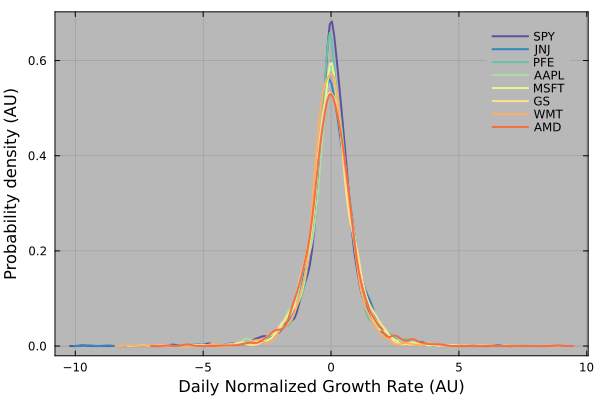

In [26]:
let

    D = training; # what data are we using?
    number_of_training_days = size(training,1); # number of days of data in training
    number_of_basis_tickers = length(basis_tickers);

    p = plot(bg="gray72", background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        foreground_color_grid=:black) # make an empty plot
    for i ∈ 1:number_of_basis_tickers
        j = basis_ticker_lookup[i];
        ticker = basis_tickers[i];
        density!(D[:,j], label="$(ticker)", c=my_color_dictionary[i], lw=2)
    end
    current();
    
    xlabel!("Daily Normalized Growth Rate (AU)", fontsize=18)
    ylabel!("Probability density (AU)", fontsize=18)
end

`Unhide` the code block below to see how we plotted the daily growth rate time series for the firms in the `basis_tickers::Array{String,1}` array for the training data. There should be `number_of_training_days::Int64` values for each element of the `basis_tickers::Array{String,1}` array.

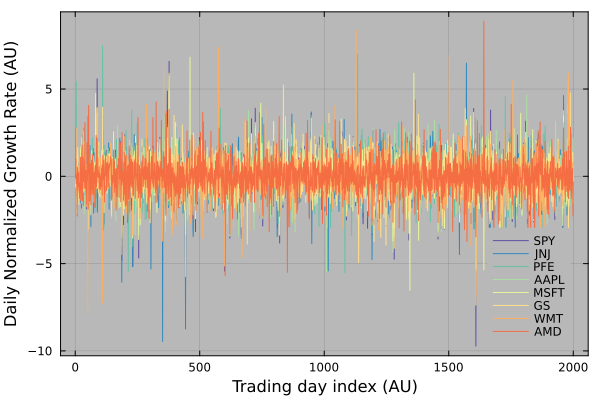

In [28]:
let

    D = training; # what data are we using?
    number_of_training_days = size(training,1); # number of days of data in training
    number_of_basis_tickers = length(basis_tickers);

    p = plot(bg="gray72", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    for i ∈ 1:number_of_basis_tickers
        j = basis_ticker_lookup[i];
        ticker = basis_tickers[i];
        plot!(D[:,j], label="$(ticker)", c=my_color_dictionary[i])
    end
    current();

    xlabel!("Trading day index (AU)", fontsize=18)
    ylabel!("Daily Normalized Growth Rate (AU)", fontsize=18)
end

## Task 2: Kernel Regression of a ticker in terms of the basis tickers
In this task, we'll use the growth rate data for the tickers in the `basis_tickers::Array{String,1}` array, and data for an unknown (to be specified) ticker to estimate the expansion weights $\alpha$.

Let's start by specifying some ticker that we want to model in the `ticker_to_model::String` variable:

In [30]:
ticker_to_model = "MRK"; # you choose a ticker symbol

Next, we'll specify the kernel that we are going to use. In theory, we choose [any kernel function that is exported by the `KernelFunctions.jl` package](https://juliagaussianprocesses.github.io/KernelFunctions.jl/stable/). We've picked a few of the standard kernels below, uncomment the one you want to use.
In addition to the choosing the kernel function, you can also specify a value for the [regularization parameter $\lambda>0$](https://en.wikipedia.org/wiki/Regularization_(mathematics)).

In [32]:
λ = 0.5; # pick a regularization parameter  (must be > 0)
γ = 0.5; # pick a scale parameter
k = SqExponentialKernel() ∘ ScaleTransform(γ); # RBF kernel w/a scaling parameter for each basis feature
# k = LinearKernel(); # inner product

__Estimate $\alpha$ parameters__. The $\alpha$ parameters are the expansion weights that appear in the kernel expansion expression, i.e., 
$$
\begin{equation}
\hat{y} = \sum_{i=1}^{n}\alpha_{i}\,k(\hat{\mathbf{z}},\hat{\mathbf{x}}_{i})
\end{equation}
$$
where $\hat{y}$ denotes the predicted output corresponsing to the input vector $\hat{\mathbf{z}}$. From our theory discussion, we know that the $\alpha$ coefficients are given by:
$$
\begin{equation}
\alpha = \left(\mathbf{K}^{\prime}+\lambda\mathbf{I}\right)^{-1}\mathbf{y}
\end{equation}
$$

In [34]:
α, XM = let

    # compute the y (thing we want model)
    D = training; # what data set are we using?
    number_of_training_days = size(training,1); # number of days of data in training
    j = findfirst(s-> s == ticker_to_model, list_of_all_tickers); # index of the ticker that we want to model
    y = D[:,j]; # ticker that we want to model -

    # compute the features matrix X (instance on rows, features on cols)
    number_of_basis_tickers = length(basis_tickers);
    XM = zeros(number_of_training_days, number_of_basis_tickers + 1);
    for row ∈ 1:number_of_training_days
        for col ∈ 1:number_of_basis_tickers
            j = basis_ticker_lookup[col];
            XM[row,col] = D[row,j];
        end
        XM[row,end] = 1.0; # augmented vector has a 1 at the end
    end
    
    # compute K, etc -
    # K = XM*transpose(XM);
    K = zeros(number_of_training_days,number_of_training_days);
    for i ∈ 1:number_of_training_days
        vᵢ = XM[i,:];
        for j ∈ 1:number_of_training_days
            vⱼ = XM[j,:];
            K[i,j] = k(vᵢ,vⱼ);
        end
    end
    IM = Matrix(1.0I,number_of_training_days,number_of_training_days);
    
    # compute α -
    α = inv(K+λ*IM)*y;
    
    # # return -
    α, XM
end;

__Test performance__: Let's compute the performance of the kernel regression model using the test data. We'll save the _predicted_ scaled growth rate values in the `ŷ::Array{Float64,1}` vector, and the _actual_ growth rate in the `y::Array{Float64,1}` vector.

In [36]:
ŷ,y = let

    # setup
    D = training; # what data are we going to use?
    number_of_prediction_days = 791; # how many days to we want to simulate?
    number_of_training_points = size(training,1);
    number_of_basis_tickers = length(basis_tickers);
    
    # compute actual -
    j = findfirst(s-> s == ticker_to_model, list_of_all_tickers); # index of ticker
    y = zeros(number_of_prediction_days);
    for d ∈ 1:number_of_prediction_days
        y[d] = test[d,j]; # this is what is observed for ticker_to_model
    end

    # compute predicted return -
    ŷ = zeros(number_of_prediction_days);
    for d ∈ 1:number_of_prediction_days

        # generate a *new* feature vector for the basis tickers
        z = zeros(number_of_basis_tickers+1);
        for ticker ∈ 1:number_of_basis_tickers
            j = basis_ticker_lookup[ticker];
            z[ticker] = test[d,j]; # look up values from test for each basis ticker
        end
        z[end] = 1.0; # augmented, has a 1 on the end

        # compute the prediction ŷ - 
        tmp = 0.0;
        for t ∈ 1:number_of_training_points
            xₜ = zeros(number_of_basis_tickers+1);
            for ticker ∈ 1:number_of_basis_tickers
                j = basis_ticker_lookup[ticker];
                xₜ[ticker] = training[t,j];
            end
            xₜ[end] = 1.0;
            tmp+=α[t]*k(z,xₜ); # compare the new basis feature vector to the training vector
        end
        ŷ[d] = tmp;
    end
    ŷ,y
end;

### Visualize

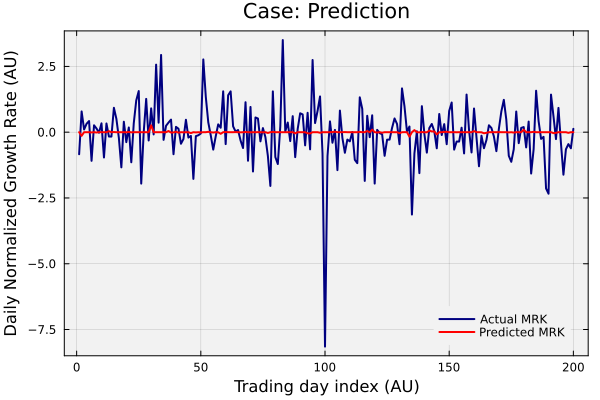

In [38]:
let
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    plot!(y[1:200], label="Actual $(ticker_to_model)", lw=2, c=:navy)
    plot!(ŷ[1:200], label="Predicted $(ticker_to_model)", lw=2, c=:red)
    
    title!("Case: Prediction", fontsize=18)
    xlabel!("Trading day index (AU)", fontsize=18)
    ylabel!("Daily Normalized Growth Rate (AU)", fontsize=18)
end

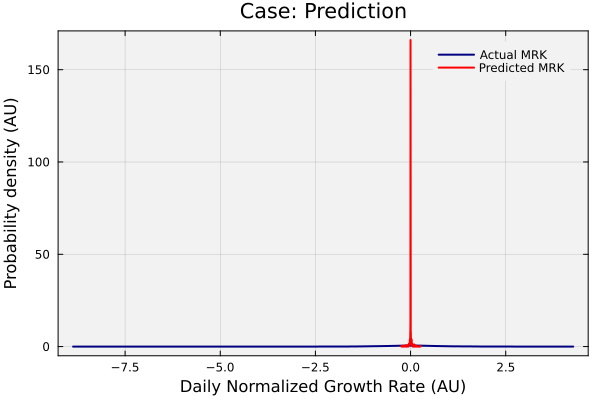

In [39]:
let
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    density!(y, label="Actual $(ticker_to_model)", lw=2, c=:navy)
    density!(ŷ, label="Predicted $(ticker_to_model)", lw=2, c=:red)

    title!("Case: Prediction", fontsize=18)
    xlabel!("Daily Normalized Growth Rate (AU)", fontsize=18)
    ylabel!("Probability density (AU)", fontsize=18)
end

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.